<a href="https://colab.research.google.com/github/axlaalq/Integer-Data-Analyst-Exam/blob/main/Examen_Integrity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importación de librerías para el análisis de datos**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

**Carga del archivo en Python y creación de un respaldo**

In [2]:
netflix_titles_original = pd.read_csv('netflix_titles.csv')
netflix_titles = netflix_titles_original.copy()
#Imprimo la información de cada columna
print('Análisis general del archivo')
print(netflix_titles.info())

Análisis general del archivo
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


**Identificación y manejo de los valores faltantes**

In [3]:
#Contar valores nulos por columna
print('Número de valores faltantes por columna')
print(netflix_titles.isnull().sum())
#Convertimos posibles cadenas vacías en valores NaN para evitar ignorar celdas vacías
netflix_titles.replace('', np.nan, inplace=True)
# Identificar las columnas con valores nulos
columnas_con_nulos = netflix_titles.columns[netflix_titles.isnull().any()]
ids_faltantes = {col: netflix_titles.loc[netflix_titles[col].isnull(), "show_id"].tolist() for col in columnas_con_nulos}

#Se pueden mostrar los indices de los valores faltantes por columna
#for columna, ids in ids_faltantes.items():
#   print(f"Columna: {columna}")
#   print(f"IDs con valores faltantes: {ids}\n")
#Guardamos los valores faltantes en un archivo Jason por si llega a ser necesario en un futuro
with open('ids_faltantes.json', 'w') as f:
    json.dump(ids_faltantes, f)

Número de valores faltantes por columna
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


**Manejo de duplicados**

In [4]:
#Identificamos las filas duplicadas en 'cast' y 'description'
#print(netflix_titles[netflix_titles.duplicated(subset=['cast',"description"], keep=False)])

#Parece que el cast se puede repetir para peliculas diferentes, pero la descripción puede indicar dos nombres o idiomas diferentes.
netflix_titles = netflix_titles.drop_duplicates(subset="description", keep="first").reset_index(drop=True)

**Limpieza básica y configuración de los tipos de datos para cada columna**

In [5]:
# Eliminar filas duplicadas basadas en la columna 'description'
netflix_titles = netflix_titles.drop_duplicates(subset="description", keep="first").reset_index(drop=True)

# Verificar que se eliminaron correctamente
print(f"Filas después de eliminar duplicados: {netflix_titles.shape[0]}")

#Primero definimos el índice del dataframe y eliminamos la letra s para asignarle un valor númerico
netflix_titles['show_id'] = netflix_titles['show_id'].str.replace('s', '')
netflix_titles['show_id'] = netflix_titles['show_id'].astype(int)
netflix_titles.set_index('show_id', inplace=True)

#Para las columnas con elemntos que se pueden repetir, voy a convertir sus valores en listas para que sea más fácil extraer información estadistica más adelante.
netflix_titles[["cast", "listed_in", "country"]] = netflix_titles[["cast", "listed_in", "country"]].map(lambda x: x.split(", ") if pd.notna(x) else [])
#De esta forma, también convertimos los valores faltantes en listas vacías

#Para asegurarnos de que todos los elementos se conviertan al mismo formato, eliminamos posibles espacios al final o al inicio de las columnas del tipo string
netflix_titles['type'] = netflix_titles['type'].str.strip()
netflix_titles['rating'] = netflix_titles['rating'].str.strip()
netflix_titles['date_added'] = netflix_titles['date_added'].str.strip()

#Defino el tipo de datos de las categorías y las fechas como corresponde
netflix_titles['date_added'] = pd.to_datetime(netflix_titles['date_added'], format='%B %d, %Y')
netflix_titles[["type","rating"]] = netflix_titles[["type","rating"]].astype("category")

#Para 'duration', separo las unidades para poder manejar la duración según el tipo de elemento
netflix_titles[['duration', 'duration_unit']] = netflix_titles['duration'].str.split(' ', expand=True)
#Dejaré el Dtype como float para que no consideren los valores faltantes en las estadísticas
netflix_titles['duration'] = pd.to_numeric(netflix_titles['duration'], errors='coerce')
#Reubicamos la nueva columna (también podría ser eliminada con netflix_titles.pop("duration_unit") de ser necesario, pero en este caso la dejaré).
netflix_titles.insert(netflix_titles.columns.get_loc("duration") + 1, "duration_unit", netflix_titles.pop("duration_unit"))

#Extra: La parte de definir los tipos de datos por columna no la piden explicítamente en las instrcciones, pero ahorra memoria y mejora el rendimiento para grandes volumenes de datos

#Verificamos que no se hayan creado nuevos valores faltantes
print('Verificiación de que no se hayan generado nuevos valores faltantes')
print(netflix_titles.isnull().sum())

Filas después de eliminar duplicados: 8775
Verificiación de que no se hayan generado nuevos valores faltantes
type                0
title               0
director         2626
cast                0
country             0
date_added         10
release_year        0
rating              4
duration            3
duration_unit       3
listed_in           0
description         0
dtype: int64


**Creación del archivo filtrado**

In [6]:
netflix_titles.to_csv("netflix_titles_clean.csv", index=False)

**Métricas descriptivas principales.**

In [7]:
from tabulate import tabulate

#Separamos las métricas de las películas y series
movies = netflix_titles[netflix_titles['type'] == 'Movie'].describe()
series = netflix_titles[netflix_titles['type'] == 'TV Show'].describe()


#usamos la librería tabulate para hacer más presentable la tabla
movies_stats = tabulate(movies, headers=['Lanzamiento en netflix', 'Año de estreno', 'Duración (min)'], tablefmt="grid")
series_stats = tabulate(series, headers=['Lanzamiento en netflix', 'Año de estreno', 'Duración (episodios)'], tablefmt="grid")

print("Estadísticas de películas:")
print(movies_stats)
print("\nEstadísticas de series:")
print(series_stats)



Estadísticas de películas:
+-------+-------------------------------+------------------+------------------+
|       | Lanzamiento en netflix        |   Año de estreno |   Duración (min) |
+=======+===============================+==================+==================+
| count | 6105                          |       6105       |        6102      |
+-------+-------------------------------+------------------+------------------+
| mean  | 2019-05-06 14:43:06.339066112 |       2013.11    |          99.4476 |
+-------+-------------------------------+------------------+------------------+
| min   | 2008-01-01 00:00:00           |       1942       |           3      |
+-------+-------------------------------+------------------+------------------+
| 25%   | 2018-04-01 00:00:00           |       2012       |          87      |
+-------+-------------------------------+------------------+------------------+
| 50%   | 2019-06-19 00:00:00           |       2016       |          98      |
+-------+----

A partir de estás tablas con los valores estádisticos más importantes de la base de datos podemos sacar las siguientes conclusiones:


*   Hay más del doble de peliculas que series de TV.
*   Solo una cuarta parte de las series se agregaron antes de 2016, mientras que el 75% de las peliculas se agregaron después de 2012.
*   Pese a que hay series con muchas temporadas y películas muy largas, la mayoría de las series no pasa de 2 temporadas y duración media de las peliculas es menor a 100 minutos.

**Gráfica de comparativa entre las peliculas y series añadidos a netflix por año**

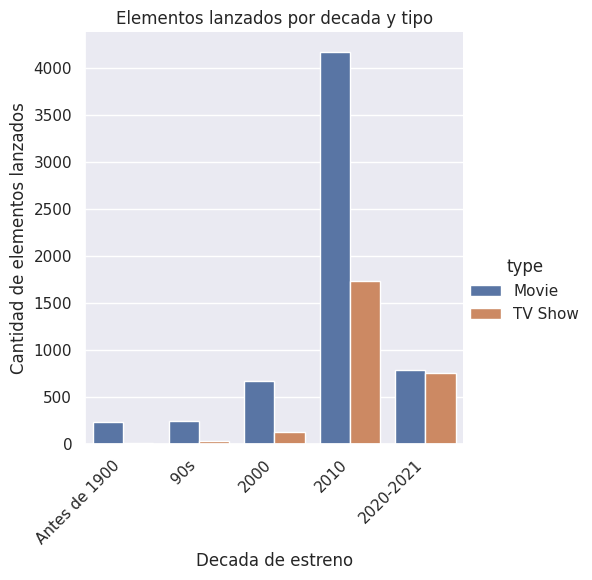

In [8]:
def get_decade(year):
    if year < 1990:
        return 1989
    else:
        return (year // 10) * 10

netflix_titles['release_decade'] = netflix_titles['release_year'].apply(get_decade)
sns.set_theme()
g=sns.catplot(x='release_decade', hue='type', data=netflix_titles, kind='count')


g.set_xticklabels(['Antes de 1900','90s','2000','2010','2020-2021'])
g.ax.get_xticklabels()[0].set_text('Anterior a 1900')
plt.xlabel('Decada de estreno')
plt.ylabel('Cantidad de elementos lanzados')
plt.title('Elementos lanzados por decada y tipo')
plt.xticks(rotation=45, ha='right')
plt.show()

La gráfica muestra los años de lanzamiento de las peliculas y series de la base de datos.


**De aquí podemos observar las siguientes tendencias:**

*   El número de estrenos se disparó despúes de 2010.
*   La cantidad de peliculas que se han lanzado entre 2020 y 2021 es mayor que las que se lanzaron en la decado de los 2000. Esto muestra una tendencia al aumento de las peliculas que se lanzan por año.



**Lanzamientos por mes**

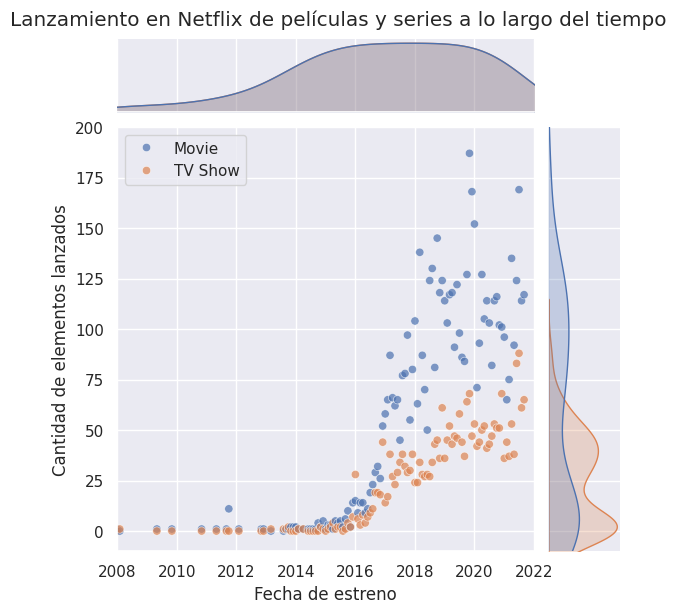

In [9]:
#Filtramos por mes y año los lanzamientos en Netflix para visualizar la tendencia que tienen las peliculas y series.
netflix_titles["year_month_added"] = netflix_titles["date_added"].dt.to_period("M")
df_filtered = netflix_titles.dropna(subset=["year_month_added", "type"])
df_count = df_filtered.groupby(["year_month_added", "type"], observed=False).size().reset_index(name="count")
df_count["year_month_added"] = df_count["year_month_added"].dt.to_timestamp()


ax=sns.jointplot(data=df_count, x="year_month_added", y="count", hue="type", kind="scatter", alpha=0.7,)
plt.xlabel('Fecha de estreno')
plt.ylabel('Cantidad de elementos lanzados')
plt.xlim(pd.to_datetime('2008'), pd.to_datetime('2022'))
plt.ylim(-10,200)
plt.legend(loc="upper left")
plt.suptitle("Lanzamiento en Netflix de películas y series a lo largo del tiempo", y=1.02)
plt.show()

Esta gráfica muestra en el centro los lanzamientos en Netflix agrupados por mes, la gráfica de la derecha nos ayuda a vizualizar como aumenta la cantidad de estrenos conforme pasa el tiempo.


* La gráfica en la parte derecha nos indica como cambia la dispersión de la cantidad de lanzamientos con el tiempo. Se puede observar que se a pesar de que hay menos lanzaientos de series, aumentan de una manera más abruta.
* La gráfica en la parte superior nos indica la dispersión las fechas de lanzamiento, como es de esperarse es la misma para peliculas y series. Muestra como van a umentando los lanzamientos hasta 2021, sin embargo al faltar información para años posteriores empieza a decaer.
* Se puede observar una tendencia al aumento de las peliculas que se agregan a netflix conforme avanza el tiempo.

**Tabla con datos generales**

In [10]:
netflix_stats = tabulate(netflix_titles[['director','listed_in','rating']].describe(include=["object", "category"]), headers=['Director', 'Generos','Clasificación'], tablefmt="grid")

print("Estadísticas generales:")
print(netflix_stats)

Estadísticas generales:
+--------+---------------+------------------------------------+-----------------+
|        | Director      | Generos                            | Clasificación   |
+========+===============+====================================+=================+
| count  | 6149          | 8775                               | 8771            |
+--------+---------------+------------------------------------+-----------------+
| unique | 4527          | 514                                | 17              |
+--------+---------------+------------------------------------+-----------------+
| top    | Rajiv Chilaka | ['Dramas', 'International Movies'] | TV-MA           |
+--------+---------------+------------------------------------+-----------------+
| freq   | 19            | 362                                | 3203            |
+--------+---------------+------------------------------------+-----------------+


De esta tabla podemos concluir que:


* El país con más péliculas en Netflix es USA. Sin embargo, el director con más películas lanzadas es Rajiv Chilaka.
* La combinación de generos más común es el drama de películas internacionales.
* La clasificación más común entre las películas de Netflix es TV-MA, lo que quiere decir que son películas para mayores de 14 años.

**Géneros más cómunes  países con más películas**

Los 5 generos más comunes son:
                     genre  count
14    International Movies   2732
12                  Dramas   2416
16                Comedies   1665
1   International TV Shows   1349
0            Documentaries    869

Países con más películas


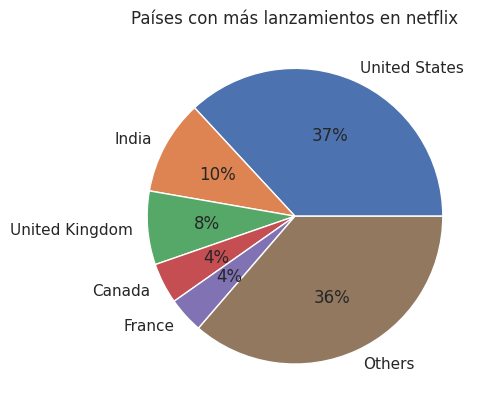

In [11]:
from collections import Counter
#Podemos crear una tabla con todos los generos posibles y cuantas veces aparecen en la base de datos
all_genres = [genre for sublist in netflix_titles["listed_in"] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=["genre", "count"]).sort_values(by="count", ascending=False)
print('Los 5 generos más comunes son:')
print(genre_df.head())

#Decidí representar los países con un gráfico de pastel para comparar mejor la cantidad de películas lanzadas de los países con más películas en netflix
print('\nPaíses con más películas')
all_countries = [country for sublist in netflix_titles["country"] for country in sublist]
country_count = Counter(all_countries)
country_df = pd.DataFrame(country_count.items(), columns=["country", "count"]).sort_values(by="count", ascending=False)
otros = country_df.tail(len(country_df) - 5).sum(numeric_only=True)
otros['country'] = 'Others'
top_5 = country_df.head(5)
country_df = pd.concat([top_5, pd.DataFrame([otros])], ignore_index=True)
plt.pie(country_df['count'],labels=country_df['country'],autopct='%.0f%%')
plt.title('Países con más lanzamientos en netflix')
plt.show()

Como ya había mencionado la combinación más común de generos son las péliculas internacionales con drama, por lo que era de esperarse que sean los generos más populares. En la gráfica de pastel es interesante ver que más de una tercera parte de todas las películas lanzadas es o es en parte de EUA.

**Actores más populares y en que clasificación de películas salen**


Los 5 actores que más aparecen son:
                 actor  count
1433       Anupam Kher     42
782     Shah Rukh Khan     35
303      Julie Tejwani     33
1634  Naseeruddin Shah     32
4942  Takahiro Sakurai     32


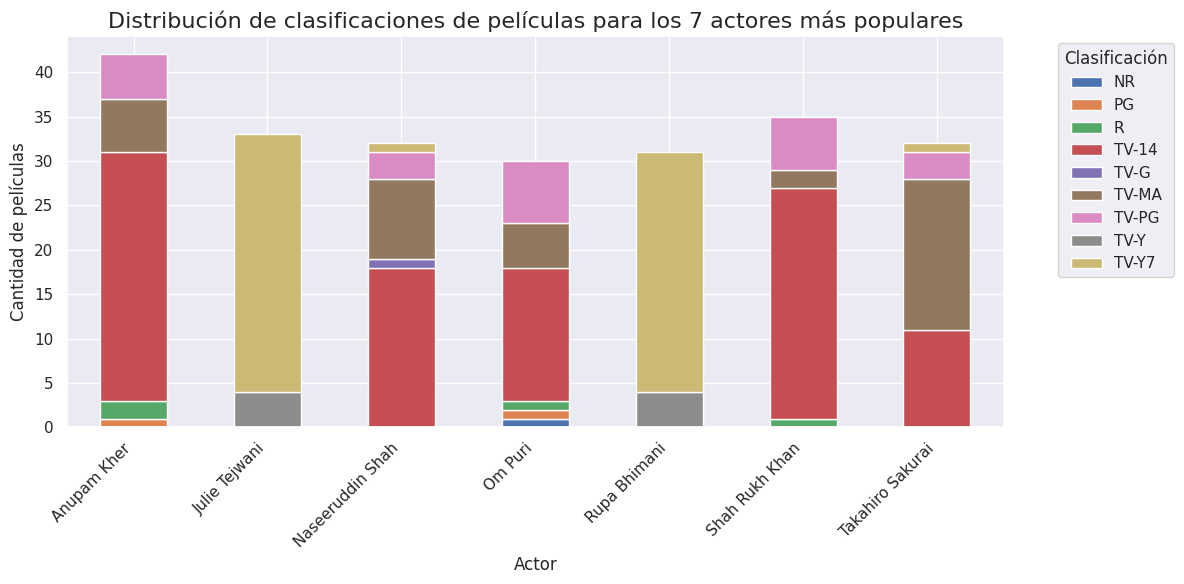

In [12]:
#Se puede hacer lo mismo que hicimos para localizar los generos más populares para los actores.
all_actors = [actor for sublist in netflix_titles["cast"] for actor in sublist]
actor_count = Counter(all_actors)
actor_df = pd.DataFrame(actor_count.items(), columns=["actor", "count"]).sort_values(by="count", ascending=False)
print('\nLos 5 actores que más aparecen son:')
print(actor_df.head())
#Primero creo un dataframe con los actores y cuantas peliculas tienen de cada clasificación
def expand_actors(df):
    new_df = []
    for index, row in df.iterrows():
        for actor in row['cast']:
            new_df.append({'actor': actor, 'rating': row['rating']})
    return pd.DataFrame(new_df)
netflix_expanded = expand_actors(netflix_titles)
merged_df = pd.merge(netflix_expanded, actor_df, on='actor', how='left')
#Filtro para incluir solo los 7 actores más populares
top_actors = actor_df.nlargest(7, 'count')['actor'].tolist()
filtered_df = merged_df[merged_df['actor'].isin(top_actors)]
grouped_data = filtered_df.groupby(['actor', 'rating']).size().unstack(fill_value=0)

#Grafico los doatos
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribución de clasificaciones de películas para los 7 actores más populares',fontsize=16)
plt.xlabel('Actor')
plt.ylabel('Cantidad de películas')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.legend(title='Clasificación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Esta gráfica nos muestra a los 7 actores más populares y en que tipo de clasificación de películas han trabajado.
* La clasificación "TV-14" parece ser la más común entre los actores presentados, seguida por "TV-MA" y "R".
* Todos los actores han participado en películas con diferentes clasificaciones. Esto sugiere que los actores no se limitan a un solo género o tipo de audiencia.

**Extra: Regresión polinomial**

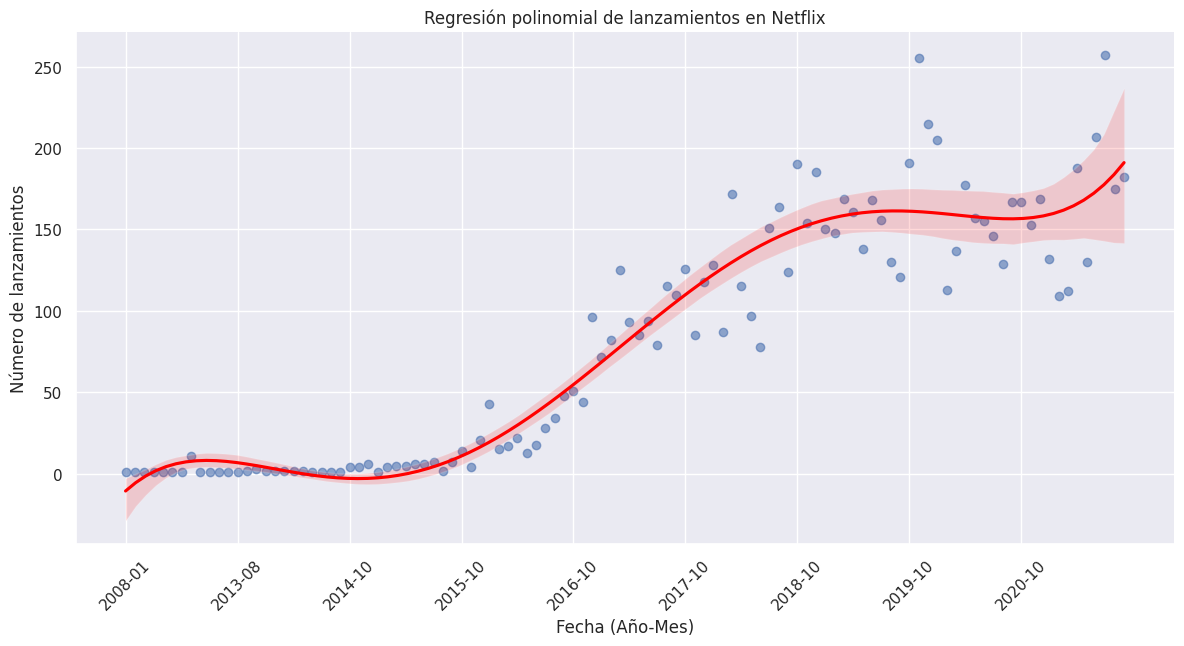

In [13]:
#Primero agrupamos los lanzmientos por mes y lo convertimos en un rango para poder gráficarlo
df_filtered = df_filtered.copy()
df_filtered["year_month"] = df_filtered["date_added"].dt.to_period("M").astype(str)
df_grouped = df_filtered.groupby("year_month").size().reset_index(name="count")
df_grouped["date_numeric"] = range(len(df_grouped))

#Usamos seaborn para buscar una regresión polinomial que se ajuste a los datos
sns.lmplot(data=df_grouped, x="date_numeric", y="count", height=6, aspect=2, line_kws={"color": "red"}, scatter_kws={"alpha": 0.6},order=5)
plt.xticks(ticks=df_grouped["date_numeric"][::12], labels=df_grouped["year_month"][::12], rotation=45)
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Número de lanzamientos")
plt.title("Regresión polinomial de lanzamientos en Netflix")
plt.grid(True)
plt.show()


En este caso fuí variando el valor de order en la siguiente línea de código hasta encontrar un grado de la regresión que se ajuste a los datos:

```
sns.lmplot(data=df_grouped, x="date_numeric", y="count", height=6, aspect=2, line_kws={"color": "red"}, scatter_kws={"alpha": 0.6},order=5)
```
Una vez encontrado ese valor, podemos crear un modelo de regresión capaz de crear predicciones.


**Predicciones para futuros lanzamientos en la plataforma con un modelo de regresión polinomial de grado 5**

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#Cambiamos el formato del dataframe creado para poder usar el modelo de la librería
X = df_grouped["date_numeric"].values.reshape(-1, 1)
y = df_grouped["count"].values

#Defino el modelo y lo ajustamos a la información de la base de datos
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

#Creo predicciones para doce meses despues del último valor de la base de datos
df_grouped["predicted"] = model.predict(X_poly)
future_dates = np.arange(len(df_grouped), len(df_grouped) + 12).reshape(-1, 1)
future_dates_poly = poly.transform(future_dates)
future_predictions = model.predict(future_dates_poly)

#Asignamos valores para las predicciones y creamos un dataframe para almacenarlas
future_months = pd.date_range(df_filtered["date_added"].max(), periods=13, freq="ME")[1:]
df_predictions = pd.DataFrame({
    "year_month": future_months.strftime("%Y-%m"),
    "date_numeric": future_dates.flatten(),
    "count": np.nan,  # No hay datos reales
    "predicted": future_predictions
})

print(df_predictions)

   year_month  date_numeric  count   predicted
0     2021-10           108    NaN  198.951839
1     2021-11           109    NaN  208.041850
2     2021-12           110    NaN  218.394956
3     2022-01           111    NaN  230.113137
4     2022-02           112    NaN  243.302581
5     2022-03           113    NaN  258.073758
6     2022-04           114    NaN  274.541495
7     2022-05           115    NaN  292.825046
8     2022-06           116    NaN  313.048169
9     2022-07           117    NaN  335.339199
10    2022-08           118    NaN  359.831120
11    2022-09           119    NaN  386.661639


Como se puede observar, el modelo predice que aumentarán bastante los lanzamientos en Netflix durante el proximo año, esto tiene sentido observando las gráficas anteriores pues se puede apreciar como han aumentado los lanzamientos rápidamente año con año.